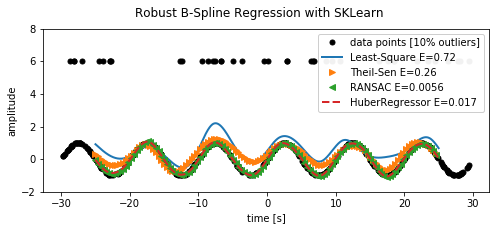

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as si
from sklearn.base import TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, RANSACRegressor,\
                                 TheilSenRegressor, HuberRegressor

from sklearn.metrics import mean_squared_error


class BSplineFeatures(TransformerMixin):
    def __init__(self, knots, degree=3, periodic=False):
        self.bsplines = get_bspline_basis(knots, degree, periodic=periodic)
        self.nsplines = len(self.bsplines)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        nsamples, nfeatures = X.shape
        features = np.zeros((nsamples, nfeatures * self.nsplines))
        for ispline, spline in enumerate(self.bsplines):
            istart = ispline * nfeatures
            iend = (ispline + 1) * nfeatures
            features[:, istart:iend] = si.splev(X, spline)
        return features


def main():
    np.random.seed(42)
    X = np.random.uniform(low=-30, high=30, size=400)
    x_predict = np.linspace(-25, 25, 1000)
    y = np.sin(2 * np.pi * 0.1 * X)
    X_test = np.random.uniform(low=-30, high=30, size=200)
    y_test = np.sin(2 * np.pi * 0.1 * X_test)

    y_errors_large = y.copy()
    y_errors_large[::10] = 6

    # Make sure that X is 2D
    X = X[:, np.newaxis]
    X_test = X_test[:, np.newaxis]

    # predict y
    knots = np.linspace(-30, 30, 20)
    bspline_features = BSplineFeatures(knots, degree=3, periodic=False)
    estimators = [('Least-Square', '-', 'C0',
                   LinearRegression(fit_intercept=False)),
                  ('Theil-Sen', '>', 'C1', TheilSenRegressor(random_state=42)),
                  ('RANSAC', '<', 'C2', RANSACRegressor(random_state=42)),
                  ('HuberRegressor', '--', 'C3', HuberRegressor())]

    fig, ax = plt.subplots(1, 1, figsize=(8, 3))
    fig.suptitle('Robust B-Spline Regression with SKLearn')
    ax.plot(X[:, 0], y_errors_large, 'o', ms=5, c='black',
            label='data points [10% outliers]')

    for label, style, color, estimator in estimators:
        model = make_pipeline(bspline_features, estimator)
        model.fit(X, y_errors_large)
        mse = mean_squared_error(model.predict(X_test), y_test)
        y_predicted = model.predict(x_predict[:, None])
        ax.plot(x_predict, y_predicted, style, lw=2, markevery=8, ms=6,
                color=color, label=label + ' E={:2.2g}'.format(mse))
    ax.legend(loc='upper right', framealpha=0.95)
    ax.set(ylim=(-2, 8), xlabel='time [s]', ylabel='amplitude')
    plt.show()


def get_bspline_basis(knots, degree=3, periodic=False):
    """Get spline coefficients for each basis spline."""
    nknots = len(knots)
    y_dummy = np.zeros(nknots)

    knots, coeffs, degree = si.splrep(knots, y_dummy, k=degree,
                                      per=periodic)
    ncoeffs = len(coeffs)
    bsplines = []
    for ispline in range(nknots):
        coeffs = [1.0 if ispl == ispline else 0.0 for ispl in range(ncoeffs)]
        bsplines.append((knots, coeffs, degree))
    return bsplines


if __name__ == "__main__":
    main()